In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import argparse
from torch.optim.lr_scheduler import OneCycleLR
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

from timm.scheduler import CosineLRScheduler

from datasets import create_datasets
from utils import *
from pathlib import Path
import torch.backends.cudnn
from sklearnex import patch_sklearn
patch_sklearn()

/home/yecm/anaconda3/envs/cv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from munch import DefaultMunch
args = DefaultMunch()
args.data_path = "../data" # cifar 是 有位置的
args.dataset = "imbalancedcifar100_100"
args.split = "full"
args.image_size = 224
args.base_model = "vit_base_patch16_224_in21k"
args.prompt_length = 10

In [4]:

norm_params = {'mean': [0.485, 0.456, 0.406],
                       'std': [0.229, 0.224, 0.225]}
normalize = transforms.Normalize(**norm_params)
train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(args.image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
val_transforms = transforms.Compose([
        transforms.Resize((args.image_size * 8 // 7, args.image_size * 8 // 7)),
        transforms.CenterCrop((args.image_size, args.image_size)),
        transforms.ToTensor(),
        normalize,  
    ])

train_dataset, val_dataset, num_classes = create_datasets(
    args.data_path, train_transforms, val_transforms, 
    args.dataset, args.split)

Files already downloaded and verified
train Mode: Contain 10847 images
Files already downloaded and verified
test Mode: Contain 10000 images


In [5]:
val_loader = DataLoader(val_dataset, batch_size=int(128), shuffle=True)
X, y = next(iter(val_loader))
X.shape, y.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [6]:
imagenet_tiny = "/data/dataset/ImageNet/tiny-imagenet-200/val"
imagenet_tiny = torchvision.datasets.ImageFolder(imagenet_tiny, transform
                                                 =transforms.Compose([
                                                     transforms.Resize(224),
                                                    transforms.ToTensor(),                                        
                                                 ]))
imagenet_tiny = DataLoader(imagenet_tiny, batch_size=128, shuffle=True)
i_X, i_y = next(iter(imagenet_tiny))
i_X.shape, i_y.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [7]:
import timm
vit = timm.create_model(args.base_model,
                                pretrained=True)
vit.head = nn.Identity()
from timm.models.vision_transformer import VisionTransformer, PatchEmbed

vit = nn.DataParallel(vit)
vit = torch.compile(vit, mode='max-autotune')
vit = vit.eval()

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vit = vit.to(device)
X = X.to(device)
y = y.to(device)
i_X = i_X.to(device)
i_y = i_y.to(device)

In [9]:
with torch.no_grad():
    vit_pred = vit(X)
    vit_pred_i = vit(i_X)

In [10]:
vit_pred.shape, vit_pred_i.shape
# 768 是 class token 在最后一层的输出。
# 每一个patch（token）的表示是 3x16x16

(torch.Size([128, 768]), torch.Size([128, 768]))

In [11]:
from PromptModels.GetPromptModel import build_promptmodel
vpt = build_promptmodel(num_classes=num_classes, img_size=args.image_size, 
                              base_model=args.base_model, model_idx='ViT', patch_size=16,
                            Prompt_Token_num=args.prompt_length, VPT_type="Deep")  # VPT_type = "Shallow"
ckpt = torch.load('../save/vpt_deep_tuned_cifar-lt/exp8/max-va.pth', 'cpu')['state_dict']
if list(ckpt.keys())[0].startswith('module'):
    ckpt_new = {}
    for key in ckpt.keys():
        ckpt_new[key[7:]] = ckpt[key]
    ckpt = ckpt_new
vpt.load_state_dict(ckpt)

vpt.head = nn.Identity()
vpt.prompt_learner.head = nn.Identity()
vpt = nn.DataParallel(vpt)
vpt = torch.compile(vpt, mode='max-autotune')
vpt = vpt.eval()
vpt = vpt.to(device)

In [12]:
with torch.no_grad():
    vpt_pred = vpt(X)
    vpt_pred_i = vpt(i_X)

In [13]:
vpt_pred.shape, vpt_pred_i.shape

(torch.Size([128, 768]), torch.Size([128, 768]))

In [18]:
linear_probe = timm.create_model(args.base_model,
                                    pretrained=True)
for param in linear_probe.parameters():
    param.requires_grad_(False)
linear_probe.head = nn.Linear(768, num_classes) 
ckpt = torch.load('../save/vit_linear_probe_cifar-lt/exp3/max-va.pth', 'cpu')['state_dict']
linear_probe.load_state_dict(ckpt)
linear_probe.head = nn.Identity()
linear_probe = nn.DataParallel(linear_probe)
linear_probe = torch.compile(linear_probe, mode='max-autotune')
linear_probe = linear_probe.eval()
linear_probe = linear_probe.to(device)


In [19]:
with torch.no_grad():
    linear_probe_pred = linear_probe(X)
    linear_probe_pred_i = linear_probe(i_X)
linear_probe_pred.shape, linear_probe_pred_i.shape

(torch.Size([128, 768]), torch.Size([128, 768]))

In [20]:
LDA_X = torch.vstack((vit_pred_i, vit_pred, vpt_pred_i, vpt_pred, linear_probe_pred_i, linear_probe_pred, )).cpu().detach().numpy()
LDA_X.shape

(768, 768)

In [21]:
import numpy as np
# classes = ['ViT-ImageNet', 'ViT-CIFAR100-LT', 'VPT-ImageNet', 'VPT_CIFAR100-LT']
classes = ['ViT-ImageNet', 'ViT-CIFAR100-LT', 'VPT-ImageNet', 'VPT_CIFAR100-LT', 'LinearProbe-ImageNet', 'LinearProbe-CIFAR100-LT']
k = 128
LDA_Y = np.array(sum([[i]*k for i in range(len(classes))], start=[]))
LDA_Y.shape

(768,)

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(LDA_X, LDA_Y)
transformed_x = lda.transform(LDA_X)
transformed_x.shape

(768, 3)

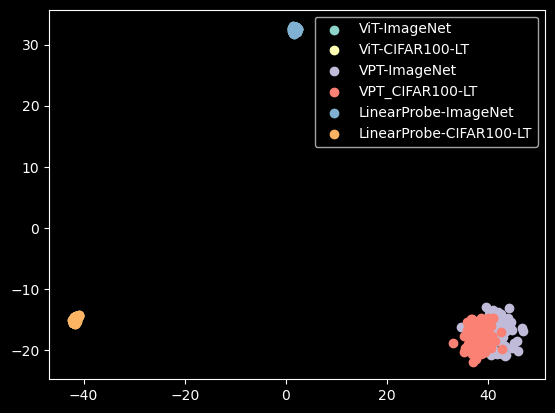

In [23]:
from matplotlib import pyplot as plt
def draw2d(X, y, label_names, file_name="LDA2D"):
    for i, name in enumerate(label_names):
        plt.scatter(X[y[:]==i, 0], X[y[:]==i, 1], label=name)
    plt.legend()
    plt.savefig(f'fig/{file_name}.png')
# draw2d(transformed_x, LDA_Y, classes)
draw2d(transformed_x, LDA_Y, classes, 'LDA2D-6class')

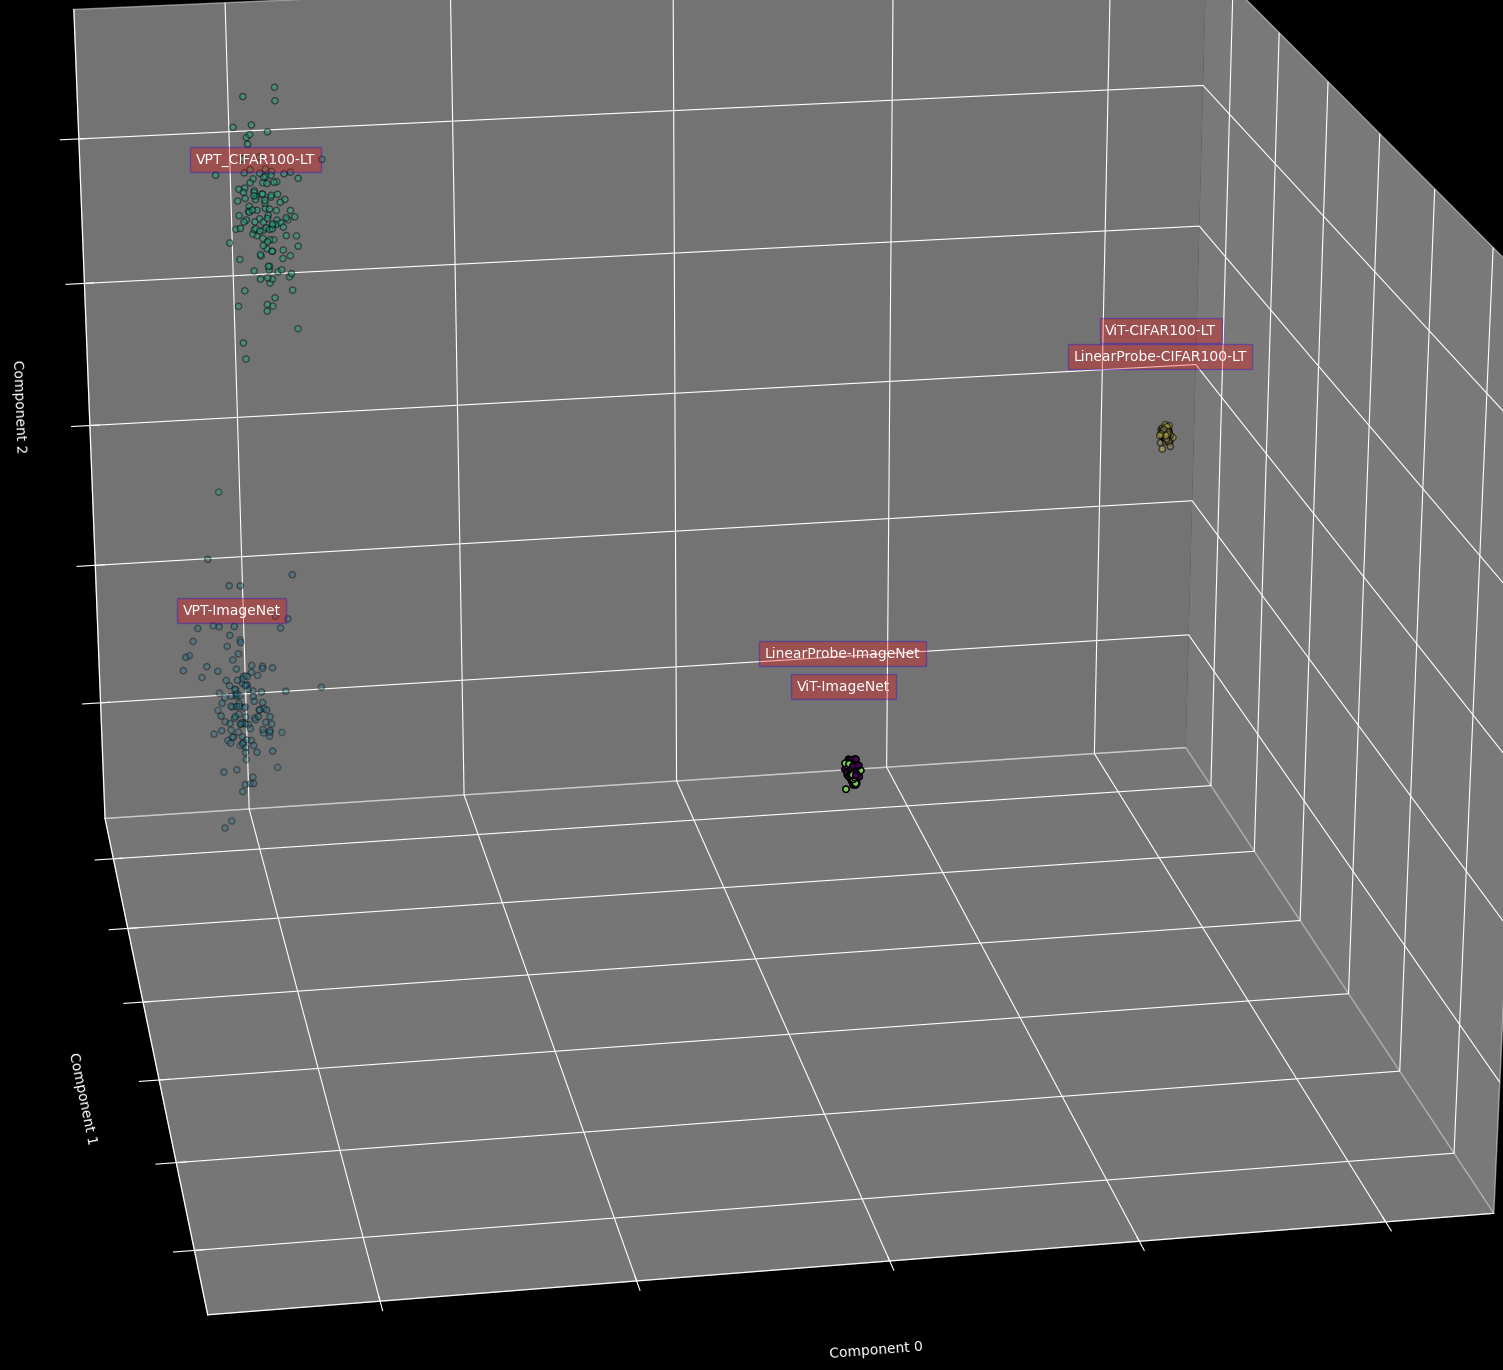

In [34]:
import random
# def draw(X, y, label_names,  file_name="LDA3D", elev=60, azim=30):
def draw(X, y, label_names, file_name="LDA3D", elev=20, azim=80):
    # X = np.array(X)
    # y = np.array(y)
    fig = plt.figure(1, figsize=(12, 12))
    # fig = plt.figure(1, figsize=(12, 15))
    ax = fig.add_subplot(111, projection="3d", elev=elev, azim=azim) 
    ax.set_position([0, 0, 0.95, 1])

    # for label, name in enumerate(label_names[4:7]):
    for label, name in enumerate(label_names):
        ax.text3D(
            X[y == label, 0].mean()+random.random()*2,
            X[y == label, 1].mean()+random.random()*2,
            X[y == label, 2].mean()+2+random.random()*2,
            name,
            horizontalalignment="center",
            bbox=dict(alpha=0.3, edgecolor="b", facecolor="r"),
        )
    # Reorder the labels to have colors matching the cluster results
    # y = np.choose(y, [1, 2, 0]).astype(float)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y,
               edgecolor='k')

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

    ax.set_xlabel("Component 0")
    ax.set_ylabel("Component 1")
    ax.set_zlabel("Component 2")
    # ax.set_title("Ground Truth")
    # ax.dist = 12
    # ax.dist = 24
    ax.dist = 6

    plt.savefig(f'fig/{file_name}.png')
    # plt.show()
draw(transformed_x, LDA_Y, classes, 'LDA3D-6class')

In [49]:
torch.cuda.empty_cache()

: 